## Genome-to-Phenome Sparse Regression (G2PSR)

In [21]:
import sys
sys.path.append("..")

from bayes_G2PSR import G2PSR
from gpu import DEVICE
import torch as pt
import pandas as pd
import numpy as np
import time
import copy
from plotnine import *

# Evaluation metric for synthetic data
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
from sklearn.metrics import r2_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

### Load and format synthetic data for G2PSR

Synthetic data generated with `synthetic_data.py` file found in [`utils`](https://gitlab.inria.fr/mlorenzi/pathways-bnn/-/tree/master/utils)

In [6]:
## Set up data directory
data_directory = "/user/mdeprez/home/Documents/BNN/benchmark_results/local_synthetic_dataset/200s_30g_15t_3tg_100tt_0.20n_0rep/"

dir_name = data_directory.split("/")
info =  dir_name[-2].split("_")
truey = [1]*int(info[3][:-2]) + [0]*(int(info[1][:-1]) - int(info[3][:-2]))

In [12]:
# Load data
X_csv=pd.read_csv(data_directory+'gen_matrix.csv', sep=';',header=None)
X_Gsnp =pd.read_csv(data_directory+'gen_snp.csv', sep=';',header=None)
W_csv = pd.read_csv(data_directory+'w_snp_target.csv', sep=';',header=None)
Y = pd.read_csv(data_directory+'target_noise.csv', sep=';',header=None).transpose()

# Data shape
print(X_csv.shape)         # (SNPs, samples)
print(X_Gsnp.shape)        # (SNPs, genes)         
print(W_csv.shape)         # (SNPs, phenotypes) Used to generate genome-to-phenome relationship in synthetic data
print(Y.shape)             # (samples, phenotypes)

(554, 200)
(554, 30)
(554, 15)
(200, 15)


The file `gen_snp.csv` contains the information associating SNPs to their respective genes.  
It is a matrix filled with 0 or 1 values with SNPs in row and Genes in columns, the value 1 associated the SNPs to the specific genes.

In [16]:
X_Gsnp.iloc[0:5, 0:5]

,0,1,2,3,4
0,1.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0
2,0.0,1.0,0.0,0.0,0.0
3,0.0,1.0,0.0,0.0,0.0
4,0.0,1.0,0.0,0.0,0.0


In [15]:
# Format data
## Genetic data is a list of tensor each element correspond to a gene and its associated SNPs.
X_group = X_Gsnp.iloc[:,:int(info[1][:-1])].to_numpy()
X_group = X_group[[i == 1 for i in np.sum(X_group, axis = 1)],:]
X_tensor = []
for i in range(0,X_group.shape[1]):
    snpGene = X_group[:,i] == 1    
    Xi = pt.tensor(X_csv.loc[snpGene.tolist(),:].to_numpy().transpose(), device=DEVICE, dtype=float)
    X_tensor.append(Xi)

Y_tensor = pt.tensor(Y.to_numpy(), device=DEVICE, dtype=float)

# Data shape
print(len(X_tensor))
print(X_tensor[0].shape) # First gene has 2 SNPs
print(Y_tensor.shape)

30
torch.Size([200, 2])
torch.Size([200, 15])


***
### Launch G2PSR

In [20]:
start_time = time.time()
g2psr=G2PSR(X_tensor, Y_tensor)
result = g2psr.optimize(X_tensor, Y_tensor, epochmax=20000, step=1000, verbose = True)
end_time = time.time()

0.0%...
1.0%...
2.0%...
3.0%...
4.0%...
5.0%...
6.0%...
7.0%...
8.0%...
9.0%...
10.0%...
11.0%...
12.0%...
13.0%...
14.0%...
15.0%...
16.0%...
17.0%...
18.0%...
19.0%...
20.0%...
21.0%...
22.0%...
23.0%...
24.0%...
25.0%...
26.0%...
27.0%...
28.0%...
29.0%...
30.0%...
31.0%...
32.0%...
33.0%...
34.0%...
35.0%...
36.0%...
37.0%...
38.0%...
39.0%...
40.0%...
41.0%...
42.0%...
43.0%...
44.0%...
45.0%...
46.0%...
47.0%...
48.0%...
49.0%...
50.0%...
51.0%...
52.0%...
53.0%...
54.0%...
55.0%...
56.0%...
57.0%...
58.0%...
59.0%...
60.0%...
61.0%...
62.0%...
63.0%...
64.0%...
65.0%...
66.0%...
67.0%...
68.0%...
69.0%...
70.0%...
71.0%...
72.0%...
73.0%...
74.0%...
75.0%...
76.0%...
77.0%...
78.0%...
79.0%...
80.0%...
81.0%...
82.0%...
83.0%...
84.0%...
85.0%...
86.0%...
87.0%...
88.0%...
89.0%...
90.0%...
91.0%...
92.0%...
93.0%...
94.0%...
95.0%...
96.0%...
97.0%...
98.0%...
99.0%...
Average difference with target: tensor(-0.0106, dtype=torch.float64, grad_fn=<MeanBackward0>)
probability that

***
### G2PSR synthetic scenario results

In [199]:
# Get perfomance metrics
truey = [1]*int(info[3][:-2]) + [0]*(int(info[1][:-1]) - int(info[3][:-2]))
compil_time = end_time - start_time

# Performance during optimization process
avg_auprc = []
auc_auprc = []
fscore = []

for i in range(0, len(result["plist"])):
    testy = copy.deepcopy(result["plist"][i])
    testy = [1-j for j in testy]
    precision, recall, thresholds = precision_recall_curve(truey,  testy)
    avg_auprc.append(average_precision_score(truey, testy))
    auc_auprc.append(auc(recall, precision))
    f1 = (2 * precision * recall) / (precision + recall)
    ix = np.argmax(f1)
    fscore.append(f1[ix])
    

<ipython-input-199-a029f96d5d75>:16: RuntimeWarning: invalid value encountered in true_divide


***
### G2PSR optimization analysis

> LOSS parameter

In [93]:
loss = []
epoch = []
for i in range(0, len(result['Losslist'])):
    loss.append(float(result['Losslist'][i]))
    epoch.append(i*1000)

loss_df = pd.DataFrame(data = {'Loss':loss, 'Epoch':epoch})

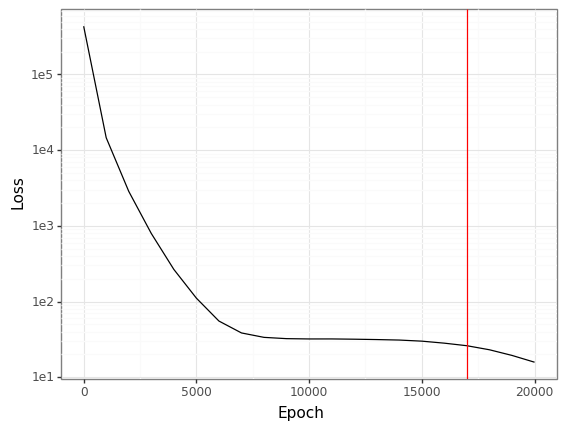

<ggplot: (8785368247065)>

In [196]:
(ggplot(loss_df, aes(x='Epoch', y='Loss'))
 + geom_line()
 + scale_y_log10()
 + theme_bw()
 + geom_vline(xintercept = 17000, color = "red")
)

> Reconstruction error

In [149]:
ynoise = pd.DataFrame(data = result['ynoise'])
ynoise.columns = ["P" + str(i) for i in ynoise.columns.tolist()]
ynoise["Epoch"] = epoch

In [151]:
ynoise_df = pd.melt(ynoise, id_vars = "Epoch", value_vars = ynoise.columns.tolist()[:-1], value_name='Sigma', var_name = "Phenotype")
ynoise_df

,Epoch,Phenotype,Sigma
0,0,P0,0.500000
1,1000,P0,0.890807
2,2000,P0,0.976064
3,3000,P0,1.010311
4,4000,P0,1.026832
...,...,...,...
295,15000,P14,0.901007
296,16000,P14,0.806893
297,17000,P14,0.655439
298,18000,P14,0.428303


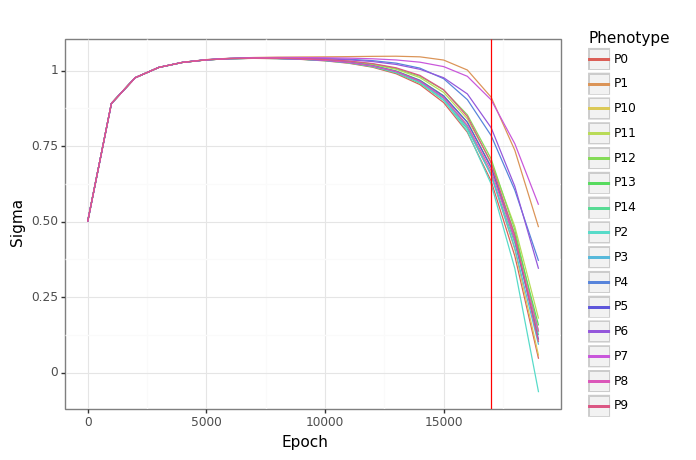

<ggplot: (8785355203744)>

In [195]:
(ggplot(ynoise_df, aes(x='Epoch', y='Sigma', color = "Phenotype"))
 + geom_line()
 + theme_bw()
 + geom_vline(xintercept = 17000, color = "red")
)

> Alpha parameter

In [176]:
alpha = pd.DataFrame(data = np.array(result['plist'])[0:21, 0:30, 0])
alpha.columns = ["G" + str(i) for i in alpha.columns.tolist()]
alpha["Epoch"] = epoch

In [177]:
alpha_df = pd.melt(alpha, id_vars = "Epoch", value_vars = alpha.columns.tolist()[:-1], value_name='Alpha', var_name = "Gene")
alpha_df

,Epoch,Gene,Alpha
0,0,G0,0.500000
1,1000,G0,0.500231
2,2000,G0,0.498193
3,3000,G0,0.498571
4,4000,G0,0.498495
...,...,...,...
625,16000,G29,0.504961
626,17000,G29,0.530400
627,18000,G29,0.558510
628,19000,G29,0.581898


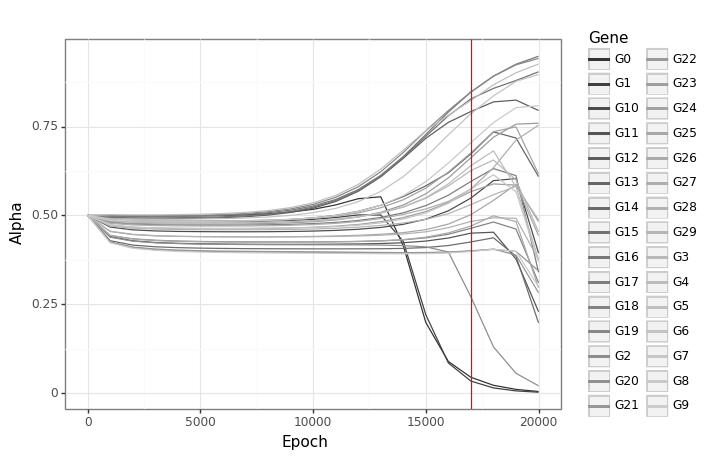

<ggplot: (8785360623496)>

In [197]:
(ggplot(alpha_df, aes(x='Epoch', y='Alpha', color = "Gene"))
 + geom_line() 
 + scale_color_grey()
 + theme_bw()
 + geom_vline(xintercept = 17000, color = "red")
)

> G2PSR performance

In [203]:
avg_df = pd.DataFrame(data = {'AUPRC':avg_auprc, 'AUC':auc_auprc, 'Fscore':fscore, 'Epoch':epoch})

/user/mdeprez/home/miniconda3/envs/vae_env/lib/python3.8/site-packages/plotnine/guides/guides.py:197: PlotnineWarning: Cannot generate legend for the 'color' aesthetic. Make sure you have mapped a variable to it


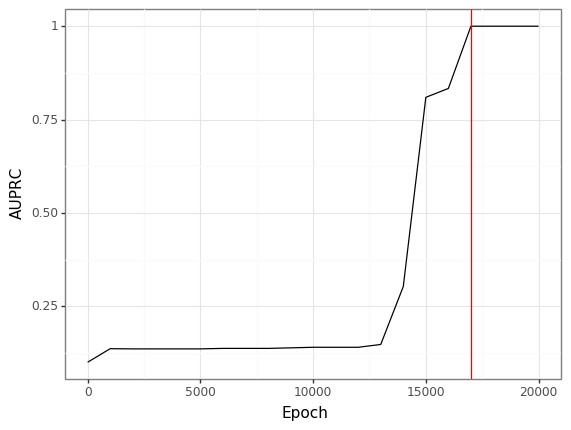

<ggplot: (8785354551315)>

In [204]:
(ggplot(avg_df, aes(x='Epoch', y='AUPRC'))
 + geom_line() 
 + scale_color_grey()
 + theme_bw()
 + geom_vline(xintercept = 17000, color = "red")
)

(21, 30)